# Instructions
In this assingment, you will be creating your very own trading algorithim by using signals to determine when you should buy or sell a stock. The goal of this assignment is to see your capabilities in coding. In the first part of the assignment, you will be writing the code for the RSI signal and another signal of your own choice. In the second part, you will use these signals to buy or sell the stock. At the end, we will see how much money you have made. 

# Step 1

Download the following packages (just run the boxes below). Do not change the code below. Note that we will be using an API package to download data from yahoo. The data is in dataframe format. You will be given the  High Price, Low Price, Close Price, Adjusted Close Price, and Volume of the stock traded on a particular day. Your task is to use the data to generate signals, which can be used to determine when to buy or sell the stock. 

In [ ]:
pip install yahoo_historical

In [26]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
import datetime
import pandas as pd

In [27]:
ticker = "GILD"
from yahoo_historical import Fetcher
data = Fetcher(ticker, [2010,1,4], [2019,6,14]) #Year, Month, Date
data = data.getHistorical()

# if isinstance(data, pd.DataFrame):
#     print("Hello")
# print(data)

In [28]:
from datetime import datetime
date_object = datetime.strptime(data.iloc[0, 0], "%Y-%m-%d")
for x in data.index[:]:
    data.iloc[x,0] = datetime.strptime(data.iloc[x,0], "%Y-%m-%d")
    

In [29]:
# print(data.columns)

# Step 2
In this step, you will be coding the RSI signal along with an additional signal of your choice. RSI readings range from 0 to 100, with readings above 70 generally interpreted as indicating overbought conditions and readings below 30 indicating oversold conditions. When deciding which other signal to choose, try to consider which signal would go well with the RSI signal. 

Please try to give plenty of comments. Also use the adjusted closing price in the data when calculating for RSI and the second signal.

In [42]:
''' Create RSI Column '''

# Define RSI period
rsi_period = 14

# Calculate Adj Close difference
change = data['Adj Close'].diff(1) 
gain = change.mask(change<0,0)

# Create new column "Gain"
data['Gain'] = gain

# Calculate Loss difference
loss = change.mask(change>0,0)

# Create new column "Loss"
data['Loss'] = loss

# Calculate average gain and average loss
avg_gain = gain.ewm(com = rsi_period - 1,min_periods = rsi_period).mean()
avg_loss = loss.ewm(com = rsi_period - 1,min_periods = rsi_period).mean()

# Create new column for average gain and average loss
data['avg_gain'] = avg_gain
data['avg_loss'] = avg_loss

# Calculate rs value
rs = abs(avg_gain / avg_loss)

# Calculate rsi value
rsi = 100 - (100/(1+rs))     # (RSI > 70) = overbought , (RSI < 30) = oversold

# Create new column to store RSI
data['rsi'] = rsi

In [43]:
#define the rsi_signal
def RSI(data, period):
    rsi_signal = []
    for i in range(data.shape[0]):
        current_rsi = data.iloc[i].rsi
        if (current_rsi) > 70:                     # Overbought
            rsi_signal.append(-1)
        elif (current_rsi) < 30:                   # Oversold
            rsi_signal.append(1)
        else:
            rsi_signal.append(0)
    return rsi_signal

In [44]:
#define second_signal
def MovingAvg(data):
    data['MA5'] = data['Adj Close'].rolling(5).mean() # Create a new column containing 5 Moving Average values
    data['MA125'] = data['Adj Close'].rolling(125).mean() # Create a new column containing 125 Moving Average values

    data.dropna() # Remove empty data
    
    shares = []
    
    for i in data.index:
        if data.loc[i, 'MA5'] > data.loc[i, 'MA125']: # Buy if 5 MA graph value is larger than 125 MA graph
            shares.append(1)
        else:  # Sell if 5 MA graph value is smaller than 125 MA graph
            shares.append(-1)
            
    return shares

# Step 3
After finishing step 2, you can now create your own trading algorithim. The singals you have created should be used in this part. The output of the signals may be an array of values, which you may use to determine if you should buy the stock or not. You may assume that you can only make a trade after the market has closed. 

In [45]:
signal1 = RSI(data, rsi_period)
signal2 = MovingAvg(data)

trades = []

for ie in data.index:
    if signal1[ie] == 1 or signal2[ie] == 1: # Always buy when one of them is buy
        trades.append(1)
    elif signal1[ie] == -1 or signal1[ie] == -1: #Always sell when one of them is sell
        trades.append(-1)
    else:
        trades.append(1)

''' 

My trading strategy: 
    
    Always buy when (5 MA > 125 MA) OR oversold, always sell when (5 MA > 125 MA) or when overbought, 
    
'''

# # Show RSI graph
# myrsi = pd.DataFrame(data, columns = ["rsi"])
# myrsi.plot(figsize = (20,10))
# plt.title("rsi")
# plt.show()
# print(signal1)

' \n\nMy trading strategy: \n    \n    Always buy when (5 MA > 125 MA) OR oversold, always sell when (5 MA > 125 MA) or when overbought, \n    \n'

If your code does not run, you will get a zero. We will not debug your code. I hope you have a fun time. 

# Evaluation of Algorithim
We have created a compute_pnl() and compute performance() function to calculate the overall profitability and performance of your trading strategy. Please do not change the underlying code. Also add the details of your performance to your report. Please include the charts that have been generated below. Note each trade costs $0.1. Also at the end of the period, all unsettled positions will be liquidated based on the final closing price of the stock. 


In [46]:
def compute_pnl(long, short, r_pnl, data, day):
    d_pnl = r_pnl
    if long:
        for x in long:
            d_pnl = d_pnl + data.iloc[day, 5] - x
    else:
        for x in short:
            d_pnl = d_pnl + x - data.iloc[day, 5]
    
    return d_pnl

In [47]:
from collections import deque
import statistics
def compute_performance(x):
    long = deque()
    short = deque()
    
    r_pnl = 0
    realized_pnl = []
    d_pnl = 0
    daily_pnl = []
    
    num_long_positions = 0;
    num_short_positions = 0;
    long_position = []
    short_position = []

    for day in data.index[:]:
        if trades[day] == -1:
            if long:
                r_pnl = r_pnl + data.iloc[day,5]- long[0] - 0.1
                long.popleft()
                num_long_positions = num_long_positions - 1
            else :
                r_pnl = r_pnl - 0.1
                short.append(data.iloc[day,5]) 
                num_short_positions = num_short_positions + 1
        
        elif trades[day] == 1:
            if short:
                r_pnl = r_pnl + short[0] - data.iloc[day,5] - 0.1
                short.popleft()
                num_short_positions = num_short_positions - 1
            else :
                r_pnl = r_pnl - 0.1
                long.append(data.iloc[day,5])
                num_long_positions = num_long_positions + 1
        else :
            pass
        
        daily_pnl.append(compute_pnl(long, short, r_pnl, data, day))
        realized_pnl.append(r_pnl)
        long_position.append(num_long_positions)
        short_position.append(num_short_positions)
        
    while long:
        r_pnl = r_pnl + data.iloc[-1,5] - long[0] - 0.1
        long.popleft()
        num_long_positions = num_long_positions - 1 
        
    while short:
        r_pnl = r_pnl + short[0] - data.iloc[-1,5]  - 0.1
        short.popleft()
        num_short_positions = num_short_positions - 1
    
    daily_pnl.append(r_pnl)
    realized_pnl.append(r_pnl)
    long_position.append(num_long_positions)
    short_position.append(num_short_positions)
        
    return r_pnl, realized_pnl, daily_pnl, long_position, short_position


In [48]:
r_pnl, realized_pnl, daily_pnl, long_position, short_position = compute_performance(trades)

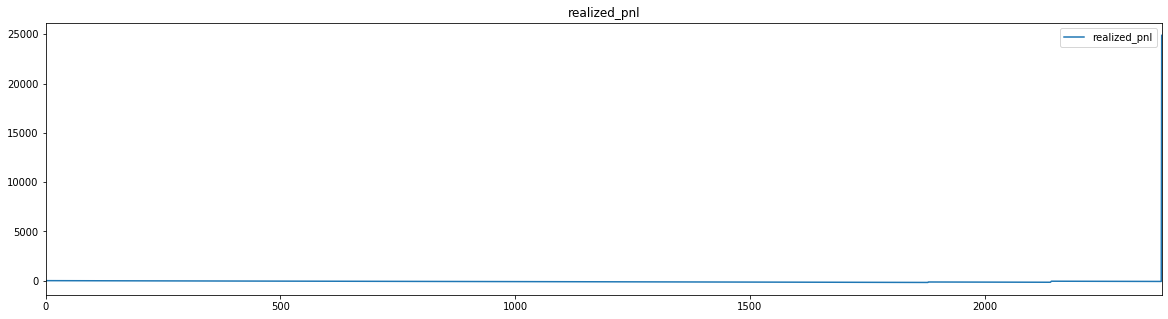

In [49]:
realized_pnl_df = pd.DataFrame(realized_pnl, columns = ["realized_pnl"])
realized_pnl_df.plot(figsize = (20,5))
plt.title("realized_pnl")
plt.show()

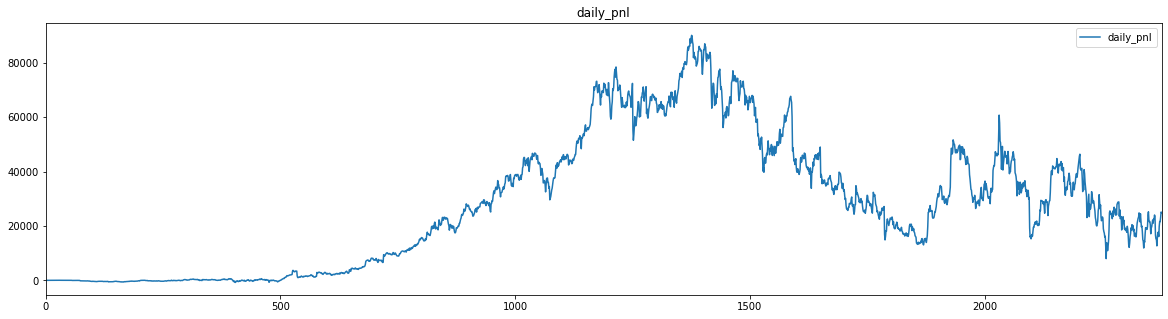

total earnings 24891.617415003897
stdev: 24118.361439026317


In [50]:
daily_pnl_df = pd.DataFrame(daily_pnl, columns = ["daily_pnl"])
daily_pnl_df.plot(figsize = (20,5))
plt.title("daily_pnl")
plt.show()
print("total earnings " + str(r_pnl))
print("stdev: " + str(statistics.stdev(daily_pnl)))

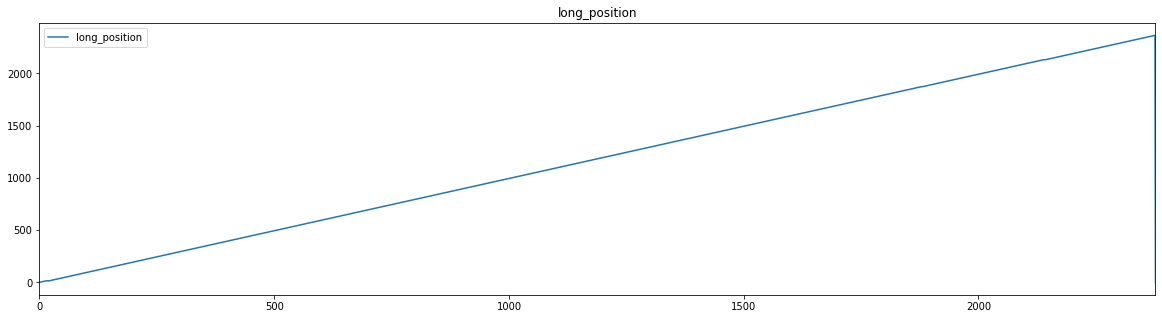

In [51]:
long_position_df = pd.DataFrame(long_position, columns = ["long_position"])
long_position_df.plot(figsize = (20,5))
plt.title("long_position")
plt.show()

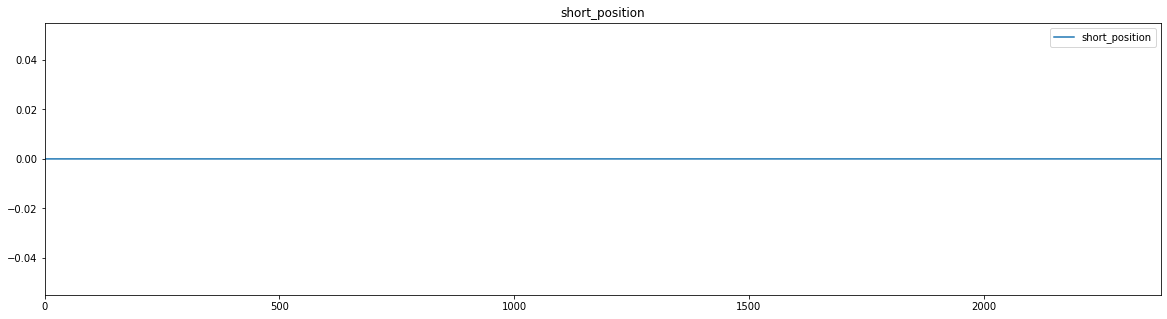

In [52]:
short_position_df = pd.DataFrame(short_position, columns = ["short_position"])
short_position_df.plot(figsize = (20,5))
plt.title("short_position")
plt.show()

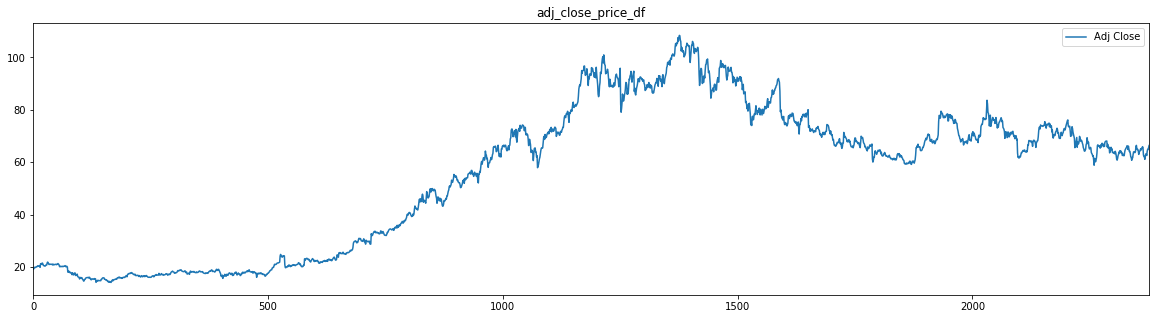

In [53]:
adj_close_price_df = pd.DataFrame(data.iloc[:,5])
adj_close_price_df.plot(figsize = (20,5))
plt.title("adj_close_price_df")
plt.show()